# Bert Training with Early Stopping

## 0. Setup

### 0.1 Install libraries

In [1]:
! pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# If you work with GPU-support:
! pip install torch==2.7.1+cu128 -f https://download.pytorch.org/whl/torch/
! pip install torchaudio==2.7.1+cu128 -f https://download.pytorch.org/whl/torchaudio/
! pip install torchvision==0.22.1+cu128 -f https://download.pytorch.org/whl/torchvision/

Looking in links: https://download.pytorch.org/whl/torch/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://download.pytorch.org/whl/torchaudio/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://download.pytorch.org/whl/torchvision/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# If you only work with CPU-support:
# ! pip install torch==2.7.1
# ! pip install torchaudio==2.7.1
# ! pip install torchvision==0.22.1

### 0.2 GPU setup

In [4]:
# Check if CUDA is available and print the current device's name
import torch
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(0))

True
0
NVIDIA GeForce RTX 2070 with Max-Q Design


## 1. Configuration

In [5]:
# Data variables
data_path = r"../../data/labeled/2025-06-28_labeled_data.xlsx" # path to the Excel file with the labeled data
text_column_name = "expanded" # name of the column containing the text to classify
label_column_name = "label_strict" # name of the column containing the labels (0 = correct or 1 = incorrect)
num_labels = 2 # binary classification (see above)

# Model configuration
model_name = "bert-base-uncased" # standard; I specify other models in the "3. Initialize Models" section of this script
test_size = 0.2 # ratio of the dataset to be used for testing
max_length = 350 # maximum length of the input sequences for BERT
num_epochs = 10 # number of epochs for training
batch_size = 16 # batch size for training and evaluation
learning_rate = 2e-5 # learning rate for the optimizer
weight_decay = 0.01 # weight decay for the optimizer
early_stopping_patience = 2 # number of epochs with no improvement after which training will be stopped

# Seed for reproducibility
import random
import numpy as np
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## 2. Read and prepare dataset

In [7]:
import pandas as pd
from sklearn.utils import resample

# Load the data
df = pd.read_excel(data_path)

# Remove all columns but 'expanded' and 'label_strict'
df = df.drop(columns=['statement_id', 'section', 'header','div', 'p', 's', 'article_id', 'p_comp', 'p_value', 'context', 'text', 'label_kind', 'label_keywords', 'label_comment'])

# Change column names
df = df.rename(columns={text_column_name: 'text', label_column_name: 'label'})

# Remove rows where 'label' is NA or -99
df = df[~df['label'].isna() & (df['label'] != -99)]

# Convert label column to int (required for classification)
df['label'] = df['label'].astype(int)

# Balance labels via undersampling (generalized)
label_counts = df['label'].value_counts()  # Get counts of each label
minority_label = label_counts.idxmin() # Get the minority label
majority_label = label_counts.idxmax() # Get the majority label

df_minority = df[df['label'] == minority_label]
df_majority = df[df['label'] == majority_label]

df_majority_downsampled = resample( # Downsample majority label
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=seed
)

df = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=seed).reset_index(drop=True)

# Show head
df.head()

,text,label
0,"As predicted, a Mann-Whitney U test indicated ...",1
1,"Contrary to Study 2, results showed no signifi...",0
2,Results revealed no significant relationship b...,0
3,There were no significant differences by gende...,0
4,"As in Study 1, individuals' risk and social pr...",1


### 2.1 Create Train/Test set

In [8]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
df_train, df_test = train_test_split(df, test_size=test_size, random_state=seed, stratify=df['label'])

# Convert to Huggingface dataset
from datasets import Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

c:\Users\Raphael\Documents\GitHub\nonsig-master-thesis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Header of the Training set:

In [9]:
df_train.head()

,text,label
462,"Step 1, in which the predictors were fine moto...",0
575,"Also, planned pairwise comparisons yielded a r...",0
556,"Again, results indicated that endorsement of d...",0
220,"Similarly, there were no significant relations...",0
423,Results revealed no significant relationships ...,0


In [10]:
# Check label balance in training set
print("Training label distribution:")
print(df_train['label'].value_counts())

Training label distribution:
label
0    263
1    263
Name: count, dtype: int64


Header of the Test set:

In [11]:
df_test.head()

,text,label
520,"Accordingly, we found no difference in respons...",0
357,We found no gender differences in task perform...,0
650,"For the opponent, significant increases in the...",0
250,There was no correlation between these two eff...,1
202,"Indeed, there was no statistically significant...",0


In [12]:
# Check label balance in test set
print("Test label distribution:")
print(df_test['label'].value_counts())

Test label distribution:
label
0    66
1    66
Name: count, dtype: int64


### 2.2 Tokenize 'text'

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_for_bert(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=max_length)

tokenized_train = train_dataset.map(tokenize_for_bert, batched=True)

tokenized_test = test_dataset.map(tokenize_for_bert, batched=True)

Map: 100%|██████████| 132/132 [00:00<00:00, 4100.40 examples/s]


## 3. Train BERT

### 3.1 Initializing model

In [14]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.2 Training regular BERT

In [ ]:
# Standard Setup for training a model with Huggingface Transformers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import EarlyStoppingCallback
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

training_args = TrainingArguments( # ERROR HERE, FIX LATER
    output_dir="./results",
    learning_rate=learning_rate, # Specify learning rate for BERT
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=weight_decay,
    logging_strategy="epoch",
    report_to="none",
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
)

# Model specific setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)]  # Stop training if no improvement after 2 epochs
)

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [ ]:
trainer.train()

Step,Training Loss
66,0.662700
132,0.297700
198,0.141400
264,0.059900
330,0.031800


TrainOutput(global_step=330, training_loss=0.23869111826925565, metrics={'train_runtime': 153.1755, 'train_samples_per_second': 17.17, 'train_steps_per_second': 2.154, 'total_flos': 473034621990000.0, 'train_loss': 0.23869111826925565, 'epoch': 5.0})

#### 3.2.1 Save last model

In [ ]:
# Save the best model and tokenizer
trainer.save_model("./best_model")
tokenizer.save_pretrained("./best_model")

### 3.3 Evaluate model

#### 3.3.1 Predict training data

In [ ]:
from sklearn.metrics import classification_report

train_preds = trainer.predict(tokenized_train)
train_preds = np.argmax(train_preds.predictions, axis=1)
GT_train = df_train['label'].tolist()
print("Training Classification Report:")
print(classification_report(GT_train, train_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       263
           1       1.00      0.99      0.99       263

    accuracy                           0.99       526
   macro avg       0.99      0.99      0.99       526
weighted avg       0.99      0.99      0.99       526



#### 3.3.2 Predict test data

In [ ]:
test_preds = trainer.predict(tokenized_test)
test_preds = np.argmax(test_preds.predictions, axis=1)
GT_test = df_test['label'].tolist()
print("Test Classification Report:")
print(classification_report(GT_test, test_preds))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        66
           1       0.97      0.89      0.93        66

    accuracy                           0.93       132
   macro avg       0.93      0.93      0.93       132
weighted avg       0.93      0.93      0.93       132



#### 3.3.3 4.3.3 Confusion-Matrix for test data

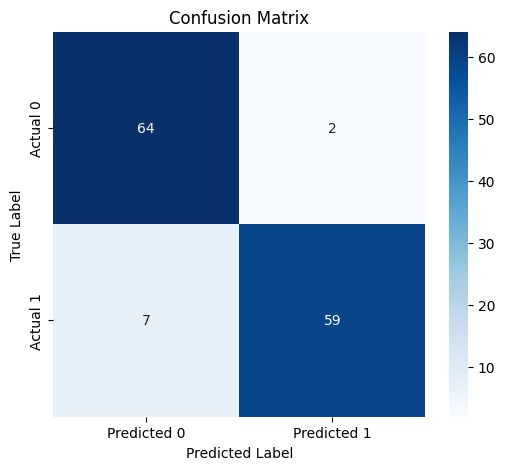

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT, preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# F1 score printout
from sklearn.metrics import f1_score
print(f"Test F1 score: {f1_score(GT_test, test_preds):.3f}")

#### 3.3.4 List of statements per category (TP, TN, FP, FN)

In [ ]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [ ]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 59)


,text
0,There was no correlation between number of ima...
1,The decline in the joy condition did not diffe...
2,"Specifically, when infants learned faces from ..."
3,"As with choices, the interaction between sure-..."
4,"When both targets were available, observers sw..."
5,"Although overall, infants had longer first fix..."
6,"This preference, however, disappeared in the e..."
7,A negative binomial regression showed no diffe...
8,There was no effect of session order for bimod...
9,"At pretest, the groups did not differ, F(2, 72..."


In [ ]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 64)


,text
0,There was neither a significant main effect of...
1,The senders' overall corrugator activity was n...
2,"In contrast, there were no significant group d..."
3,The two-way interaction between CRP and cancer...
4,The alternative explanation of an order effect...
...,...
59,The Target Ã— Valence interaction was not sign...
60,"Consequently, receivers' use of the odd-oneout..."
61,A repeated measures ANOVA on the two questions...
62,Follow-up tests revealed that the AOI Ã— Varia...


In [ ]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 2)


,text
0,"We did not observe a main effect of aperture, ..."
1,"Relying on the categorical approach, and again..."


In [ ]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 7)


,text
0,"The omnibus ANCOVA, in which posterior perceiv..."
1,The number of incongruent negative and positiv...
2,RT data showed a very similar pattern: Respons...
3,"In contrast, the mean signed response offset f..."
4,"In addition, although participants with shorte..."
5,"Importantly, there were no between-group diffe..."
6,"Gender, trait aggression, and endogenous testo..."


In [ ]:
# The end...